For most graphs, we will be using `plotnine` today, which is the equivalent of R's `ggplot2` in python. It follows the grammar of graphics. 

There are many options available in python regarding data visualization libraries, such as `matplotlib`, `altair`, `bokeh`, `seaborn`, `pygal`, ... but imo `plotnine` hits all the marks in terms of:
- pure aesthetics from scratch
- code readability / review 
- adaptability to the requirements

That being said:
- for interactive plots, we will focus on `plotly` (maps included although `folium` is nice as well)
- for network representation, we will look into the `pyvis` library

## Imports

In [1]:
# <!> please - pull all imports here as notebook cells can be run in various order

# data manipulation
import pandas as pd 

# small computations
import numpy as np

# plotnine is a dataviz library
# we need to import required elements
from mizani.transforms import trans, trans_new # scale transformations
from plotnine import * 
# from plotnine import ggplot, aes,\
#    geom_point, geom_line, geom_abline, geom_linerange, geom_count, geom_bar, geom_col,geom_histogram,geom_text,\
#        labs,theme,element_text,element_line,geom_vline,\
#            coord_flip,facet_grid,facet_wrap,scale_x_continuous,scale_y_continuous

# pyvis - network visualization
from pyvis.network import Network

# plotly
import plotly.graph_objects as go
import plotly.express as px


## Load datasets

In [2]:
from constants import characters, characters_group, characters_edges, filming_locations
characters.head()

,id,name,species,gender,height,weight,hair_color,eye_color,skin_color,year_born,homeworld,year_died,description
0,1,Luke Skywalker,Human,Male,1.72,77.0,Blond,Blue,Light,19.0,Tatooine,-34.0,The main protagonist of the original trilogy.
1,2,Leia Organa,Human,Female,1.50,49.0,Brown,Brown,Light,19.0,Alderaan,-35.0,A leader in the Rebel Alliance and twin sister...
2,3,Darth Vader,Human,Male,2.02,136.0,NaN,Yellow,Pale,41.0,Tatooine,-4.0,The Sith Lord formerly known as Anakin Skywalker.
3,4,Yoda,Yoda's species,Male,0.66,17.0,White,Brown,Green,896.0,Unknown,-4.0,A wise and powerful Jedi Master.
4,5,Han Solo,Human,Male,1.80,80.0,Brown,Hazel,Light,29.0,Corellia,-34.0,A smuggler turned hero in the Rebel Alliance.


# Graphs w/ `plotnine`

[Plotnine website](https://plotnine.org/) contains clean documentation (see Reference) and examples sorted by plot types (see Gallery). 

Todo list of geometries:
- scatterplot
- barplot
- histogram w/ facets
- boxplot
- line and linerange

We will also see how to add text and to customise your graphs

## Grammar of graphics

| Element | Methods in the code | Description |
| ------- | ----------- | ----------- |
| Data | None | the prepared input dataset |
| Aesthetics | `aes()` | links between variables and representation (x, y, fill, color, size, shape, alpha, ...) |
| Geometries | `geom_*` | type of representations (line, boxplot, histogram, point, ...) |
| Facets | `facet_*` | multiple plots of subgroups |
| Statistics | None | Parameter choices, computations done prior to plot |
| Coordinates | `scale_*`, `coord_*` | scaling elements |
| Themes | `labs()`, `theme()` | design elements of the plot, not-linked to the data |

## Scatterplot, detailed

In [3]:
# characters.loc[characters.weight > 1000]
characters.query('weight > 1000')

,id,name,species,gender,height,weight,hair_color,eye_color,skin_color,year_born,homeworld,year_died,description
41,42,Jabba the Hutt,Hutt,Male,3.9,1358.0,NaN,Orange,Green,600.0,Nal Hutta,-4.0,A notorious crime lord.


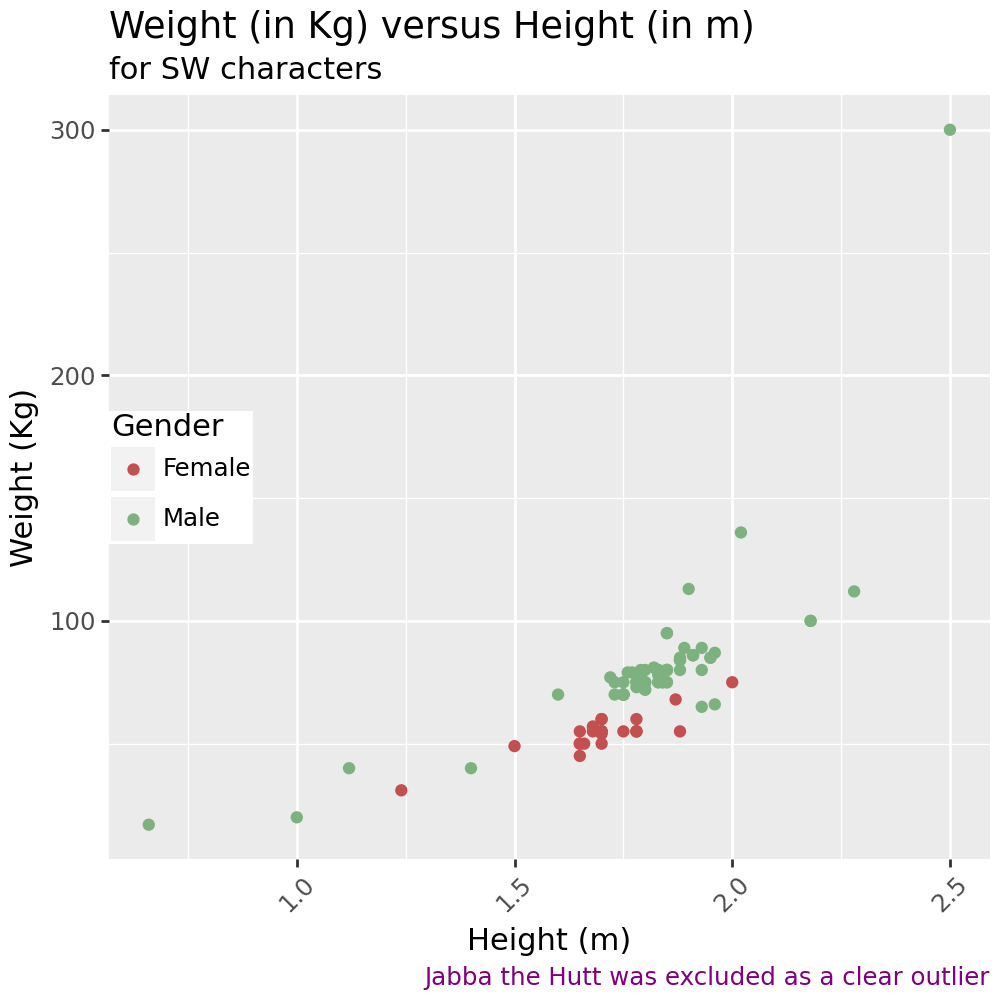

In [4]:
(
    ggplot(characters.query('weight < 1000')) # init
    +aes(x='height',y='weight', color='gender') # def aesthetics
    +geom_point() # la geometrie # if we don't want legend: show_legend=False
    +labs(
        x='Height (m)', y='Weight (Kg)', title='Weight (in Kg) versus Height (in m)', color='Gender',
     subtitle='for SW characters', caption='Jabba the Hutt was excluded as a clear outlier'
    ) # libelles
    +theme(
        figure_size=(5,5),
        plot_caption=element_text(ha='right', color='purple'), 
        axis_text_x=element_text(angle=45),
        legend_position=(0, 0.5) # top, bottom, right, left
    ) # customisation
    + scale_color_manual(values={"Male": '#7DB280', "Female": '#C34F4F'}) # choisir sa propre couleur
)

## Barplot & Countplot

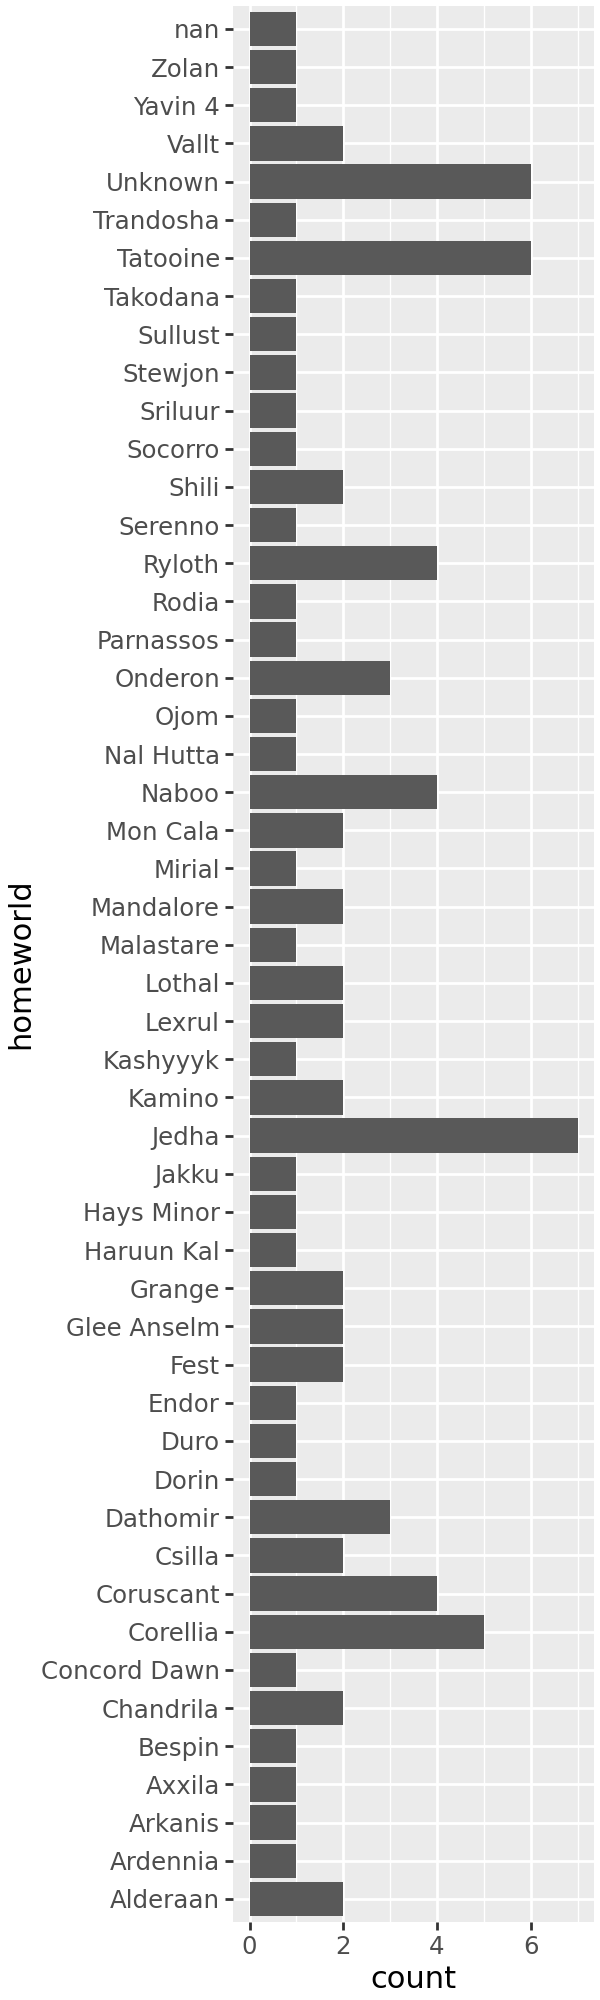

In [5]:
(
    ggplot(characters)+
    aes(x='homeworld')+
    geom_bar()+
    coord_flip()+
    theme(figure_size=(3,10))
)
# but: not sorted

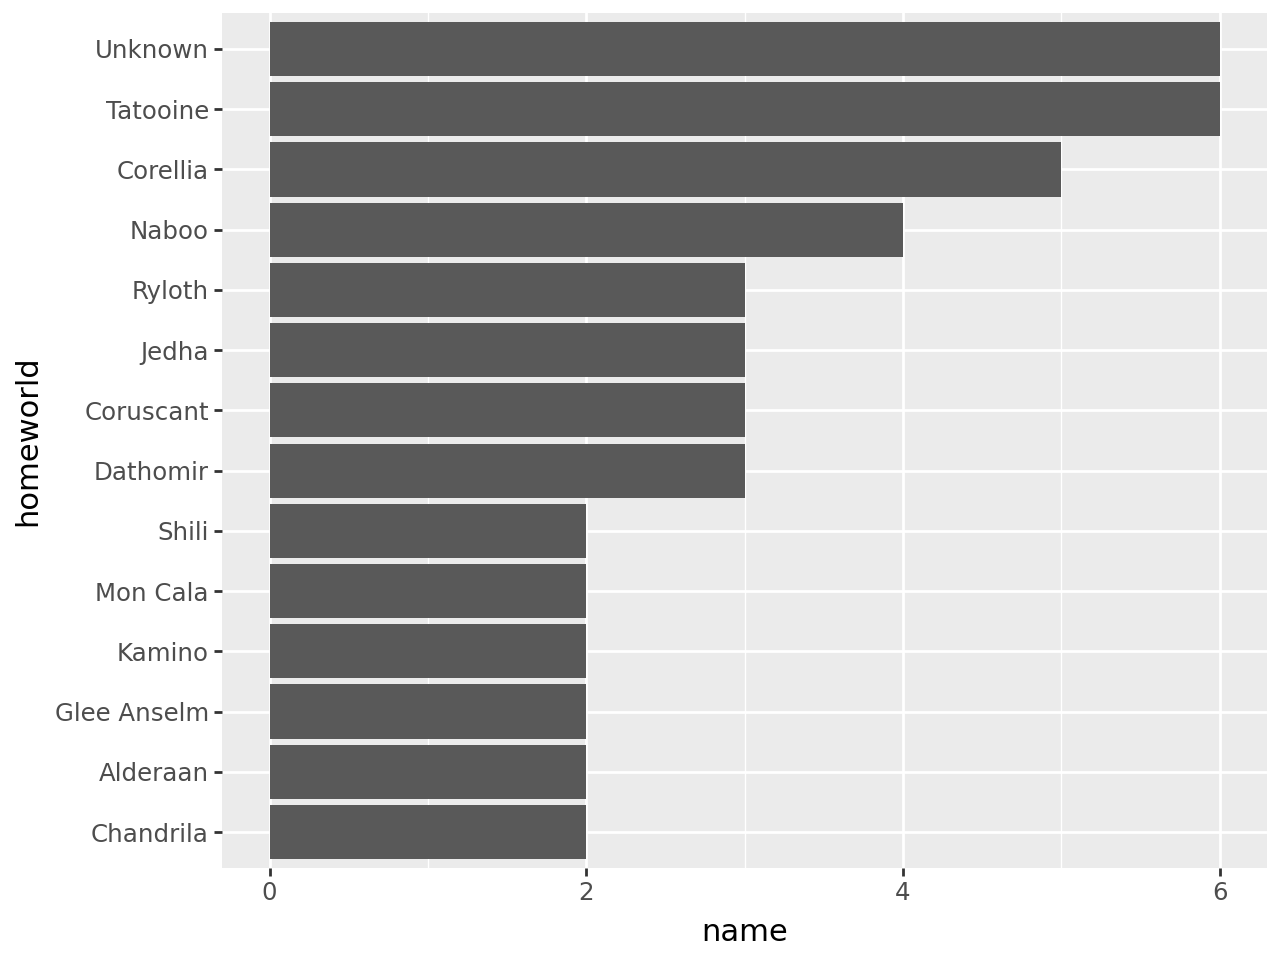

In [6]:
# barplot: nb d'individus par homeworld
tmp = (
    characters
    .groupby('homeworld')
    .name
    .nunique()
    .reset_index()
    .sort_values('name')
    .assign(homeworld = lambda df: pd.Categorical(df.homeworld, categories=df.homeworld))
)

(
    ggplot(tmp.query('name>1'))+
    aes(x='homeworld', y='name')+
    geom_col()+
    coord_flip()
)

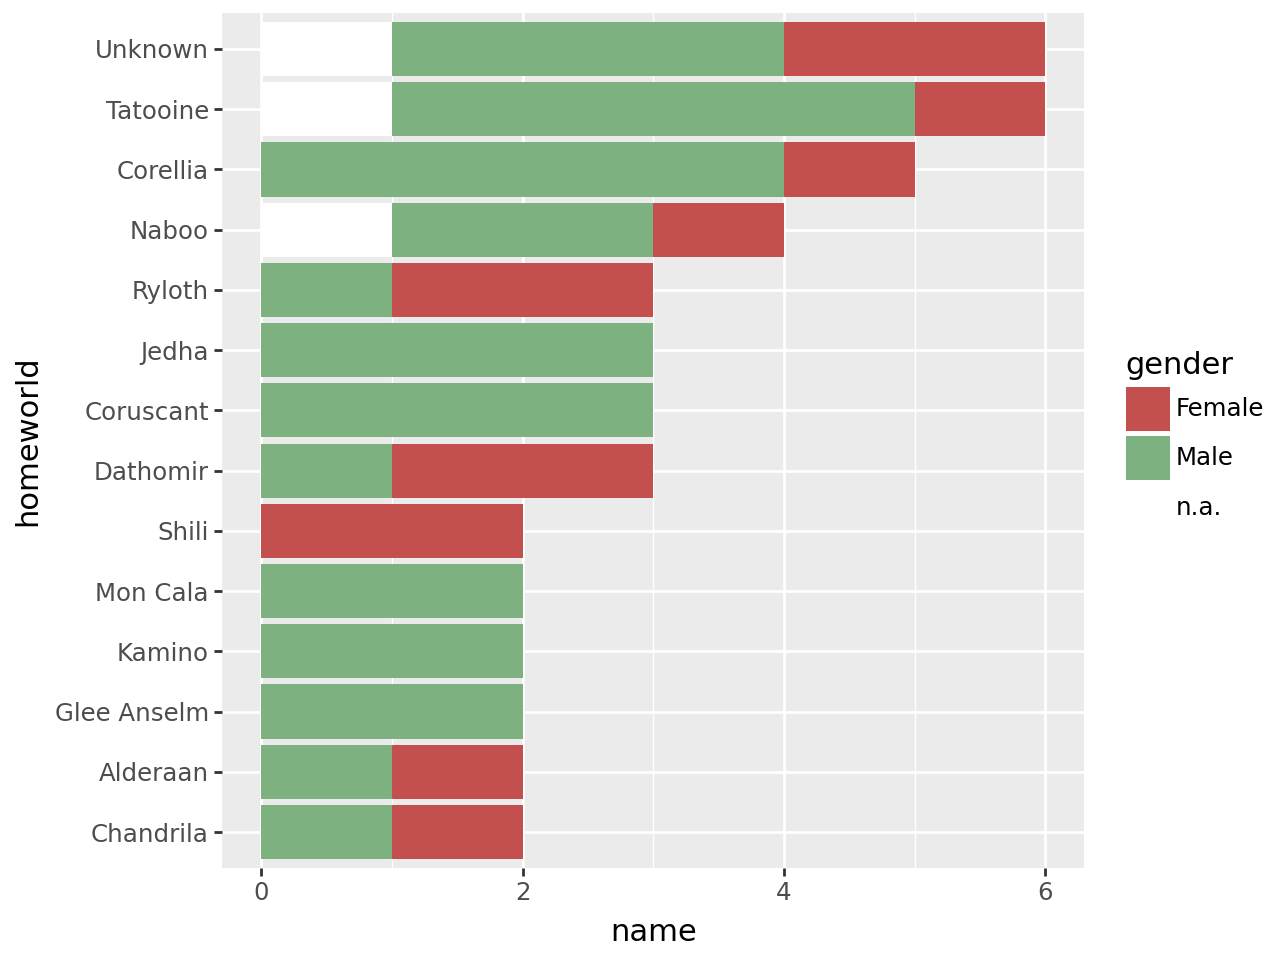

In [7]:
tmp_by_gender = (
    characters
    .fillna({'gender': 'n.a.'})
    .groupby(['homeworld','gender'])
    .name
    .nunique()
    .reset_index()
    .sort_values('name')
    .assign(homeworld = lambda df: pd.Categorical(df.homeworld, categories=tmp.homeworld.unique()))
)

sel_homeworld = tmp.query('name > 1').homeworld

(
    ggplot(tmp_by_gender.query('homeworld in @sel_homeworld'))+
    aes(x='homeworld', y='name', fill='gender')+
    geom_col()+
    scale_fill_manual(values={"Male": '#7DB280', "Female": '#C34F4F', 'n.a.': '#FFFFFF'})+
    coord_flip()
)


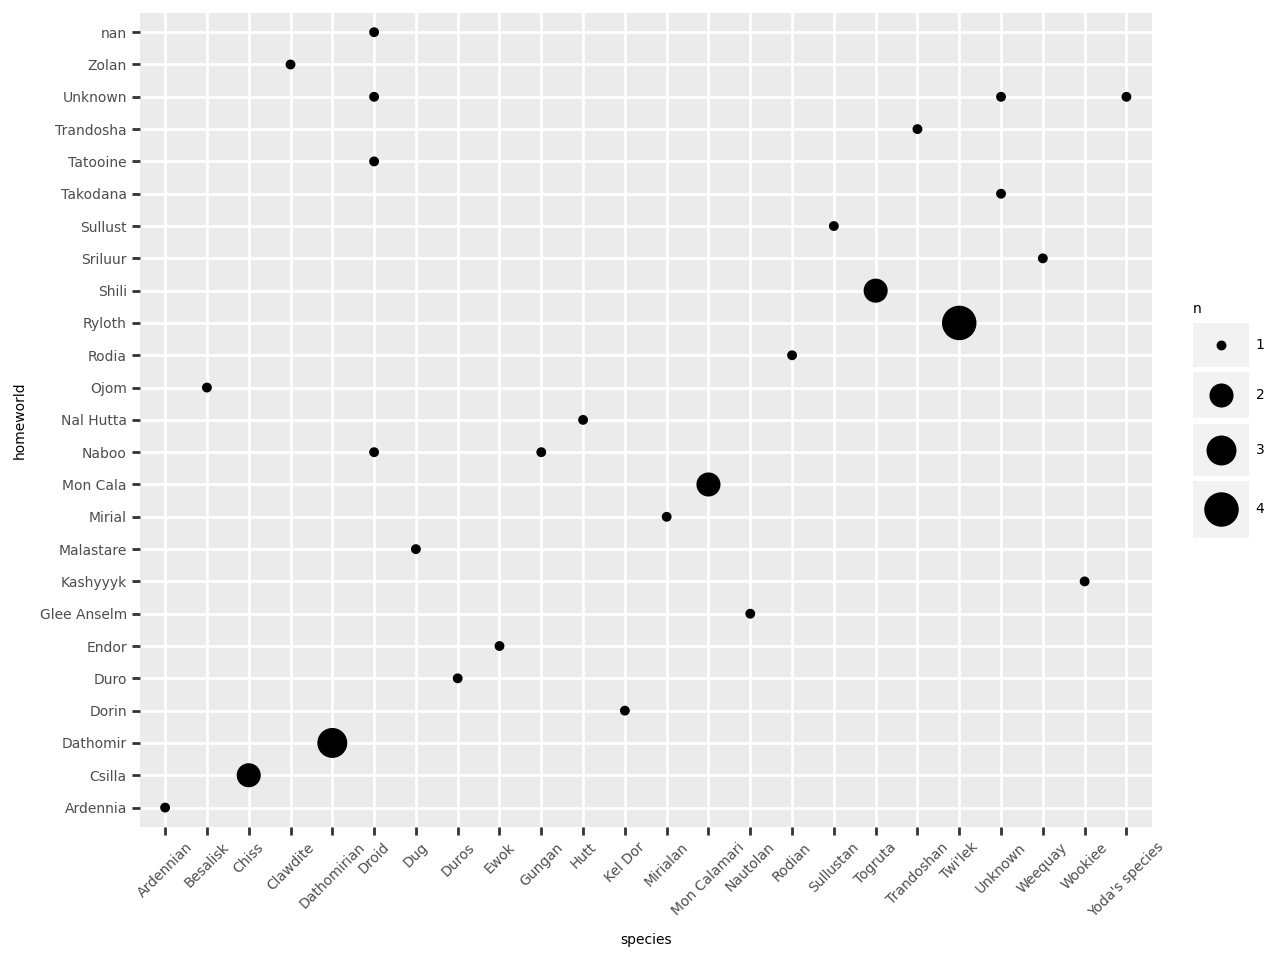

In [8]:
# here we do what is commonly known as a Bubble chart
(
    ggplot(characters.query('species != "Human"'))+
    aes(y='homeworld', x='species')+
    geom_count()+
    theme(text=element_text(size=5), axis_text_x=element_text(angle=45))
)

## Histogram across groups

/opt/conda/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 34'. Pick better value with 'binwidth'.
/opt/conda/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 4 rows containing non-finite values.


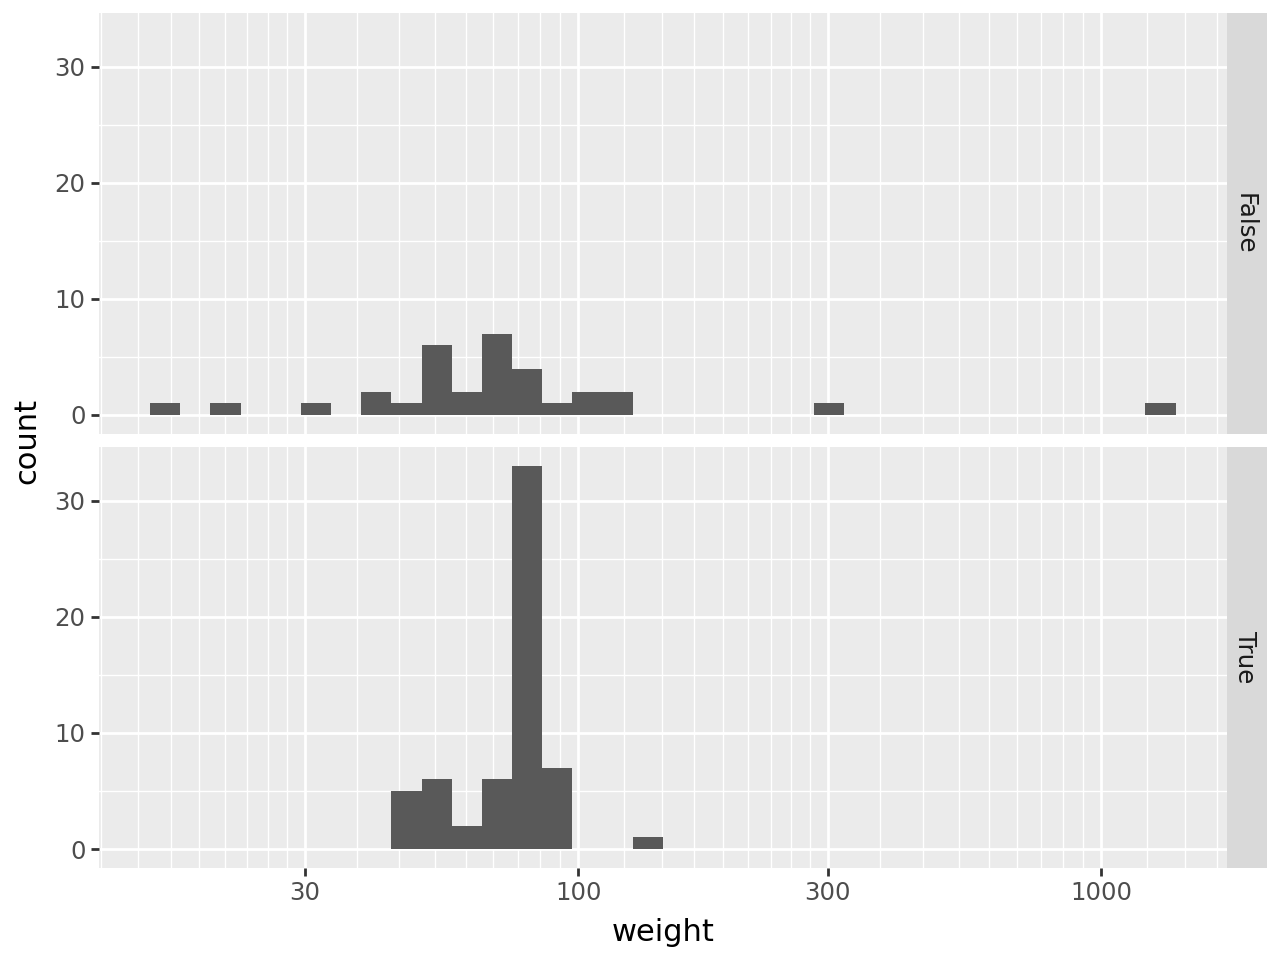

In [9]:
# distribution du poids en échelle logarithmique
# ...
# using facets
(
    ggplot(characters.assign(is_human=lambda df: df.species=="Human"))+
    aes(x='weight')+
    geom_histogram()+
    scale_x_log10()+
    facet_grid('is_human')
)

/opt/conda/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 4 rows containing non-finite values.


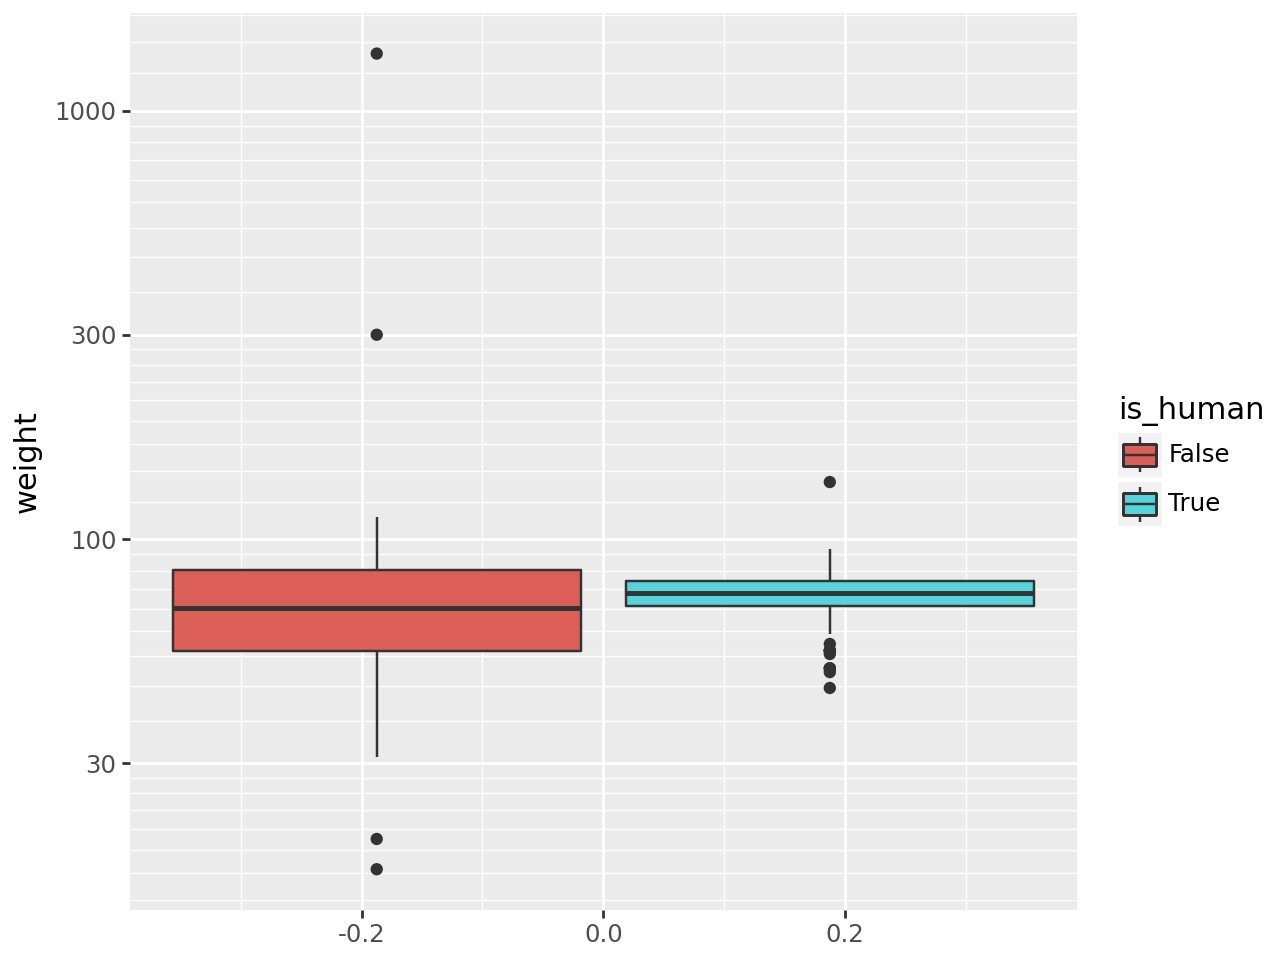

In [10]:
(
    ggplot(characters.assign(is_human=lambda df: df.species=="Human"))+
    aes(y='weight', fill='is_human')+
    scale_y_log10()+
    geom_boxplot()
    # geom_histogram(position='identity', alpha=0.4)+ # position arg position='identity'
    # geom_density(alpha=0)
)

## Heatmap

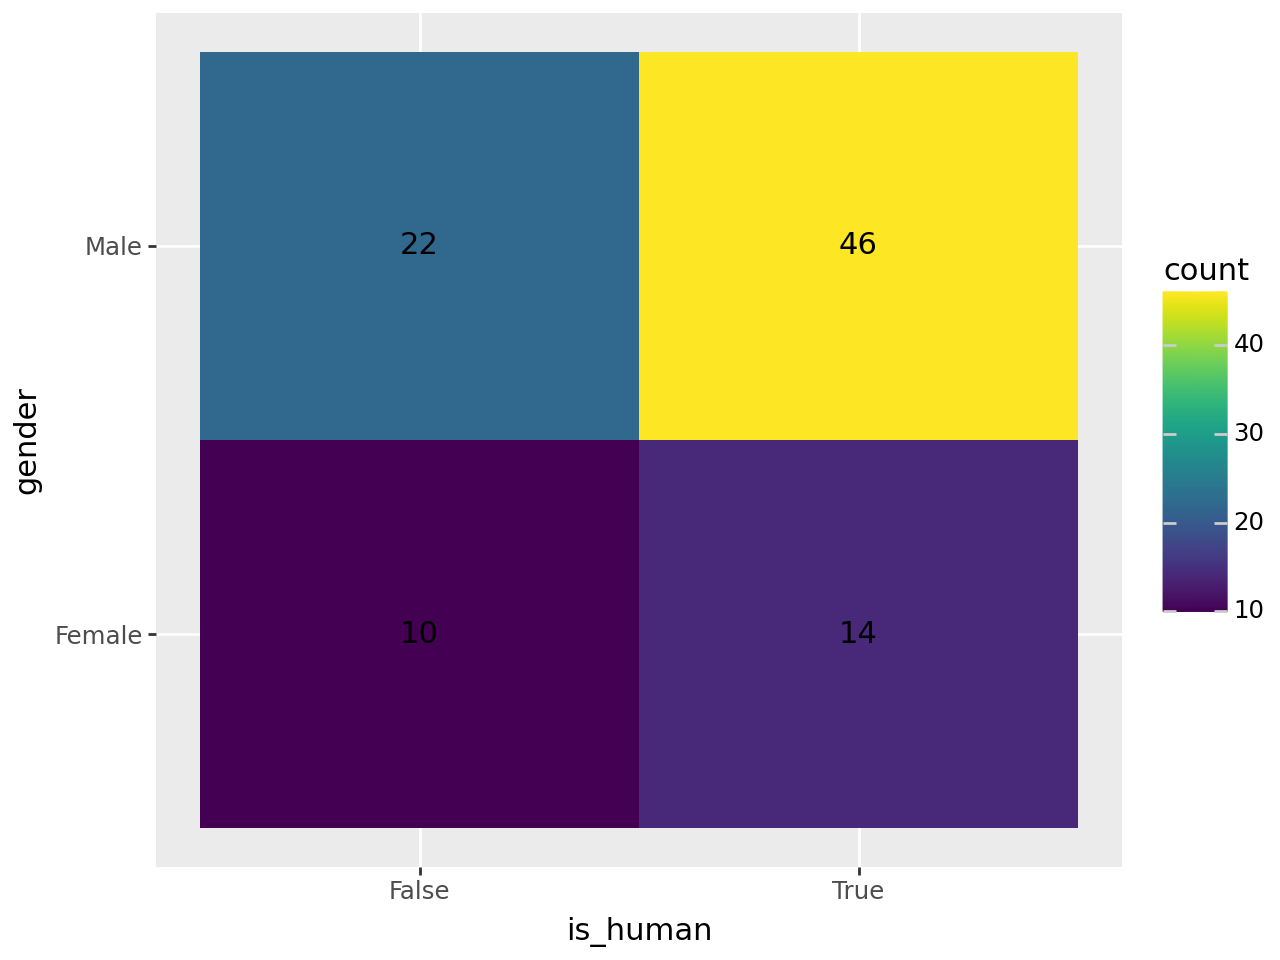

In [11]:
tmp = (
    characters
    .assign(is_human=lambda df: df.species=="Human")
    .value_counts(['is_human', 'gender'])
    .reset_index()
)

(
    ggplot(tmp)
    +aes(x='is_human', y='gender', fill='count', label='count')
    +geom_tile()
    +geom_text()
)



## Lines

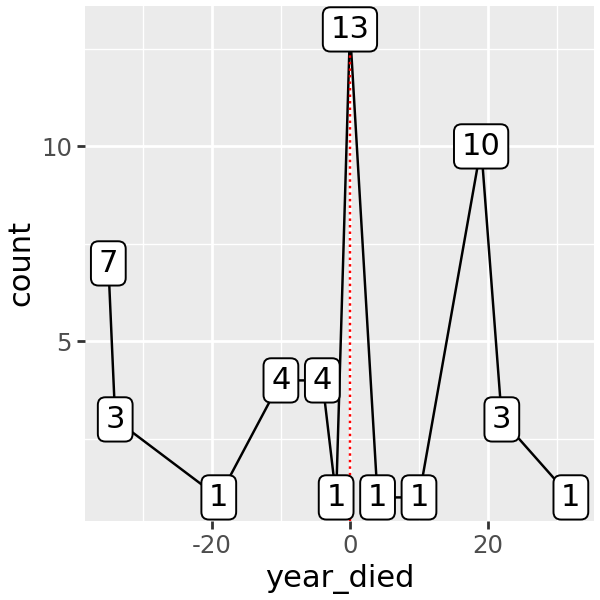

In [12]:
# (
#    ggplot(characters)
# )

tmp = (
    characters
    [['name', 'year_died']]
    .dropna()
    .drop_duplicates()
    .value_counts('year_died')
    .reset_index()
    .sort_values('year_died')
)

(
    ggplot(tmp)+
    aes(x='year_died', y='count', label='count')+
    geom_line()+ # possible to add many geometries in same graph
    geom_point()+
    geom_vline(xintercept=0, color='red', linetype='dotted')+ # geom_abline, geom_vline, geom_hline helps to put markers
    # geom_text(nudge_x=0.5, nudge_y=0.5)+ # geom_text and label adds text annotations to the graph
    geom_label()+
    theme(figure_size=(3,3))
)

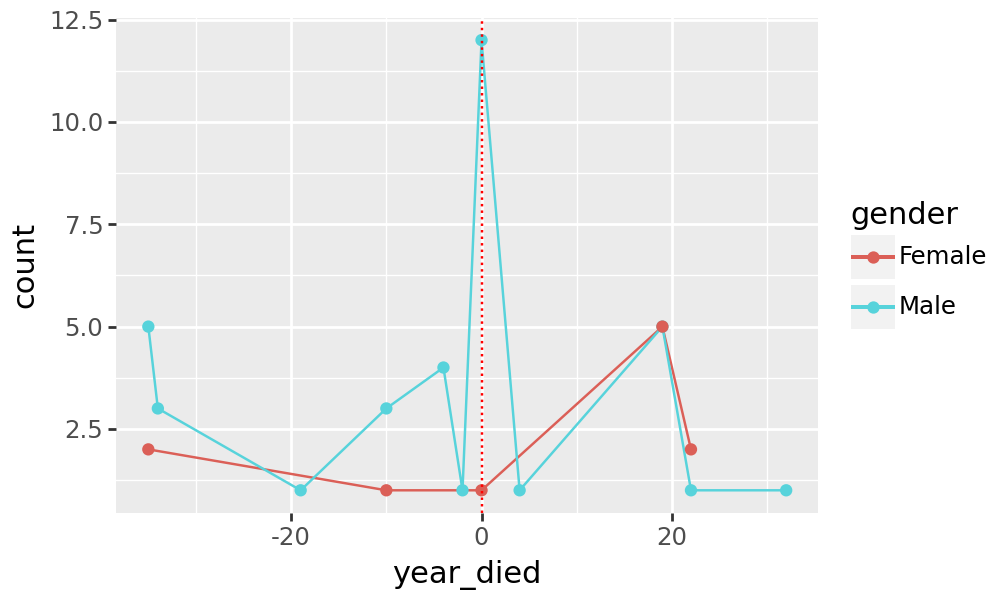

In [13]:
# (
#    ggplot(characters)
# )

tmp = (
    characters
    [['name', 'year_died', 'gender']]
    .dropna()
    .drop_duplicates()
    .value_counts(['year_died', 'gender'])
    .reset_index()
    .sort_values('year_died')
)

(
    ggplot(tmp)+
    aes(x='year_died', y='count', color='gender')+
    geom_line()+ # possible to add many geometries in same graph
    geom_point()+
    # geom_histogram()+ # not compatible ;)
    geom_vline(xintercept=0, color='red', linetype='dotted')+ # geom_abline, geom_vline, geom_hline helps to put markers
    # geom_text(nudge_x=0.5, nudge_y=0.5)+ # geom_text and label adds text annotations to the graph
    # geom_label()+
    theme(figure_size=(5,3))
)

/opt/conda/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


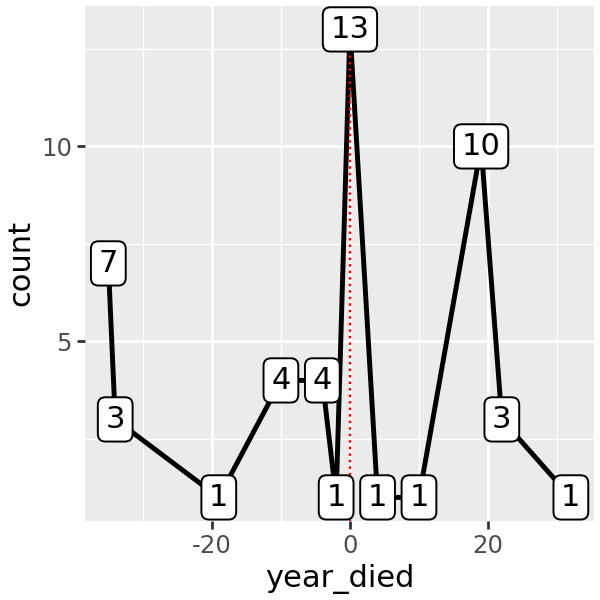

In [14]:
# (
#    ggplot(characters)
# )

tmp = (
    characters
    [['name', 'year_died']]
    .dropna()
    .drop_duplicates()
    .value_counts('year_died')
    .reset_index()
    .sort_values('year_died')
)

(
    ggplot(tmp)+
    aes(x='year_died', y='count', label='count')+
    geom_line()+ # possible to add many geometries in same graph
    geom_point()+
    geom_smooth(se=True, method='lowess', span=0.1)+
    geom_vline(xintercept=0, color='red', linetype='dotted')+ # geom_abline, geom_vline, geom_hline helps to put markers
    # geom_text(nudge_x=0.5, nudge_y=0.5)+ # geom_text and label adds text annotations to the graph
    geom_label()+
    theme(figure_size=(3,3))
)

In [15]:
def genrw(n):
    return np.cumsum(np.random.normal(size=n, loc=0, scale=1))

def genfd(p, n):
    return pd.concat([pd.DataFrame({
        "i": np.repeat(idx, n), 
        "x": range(n), 
        "y": genrw(n=n)
    }) for idx in range(p)])

fd = genfd(p=9, n=20)
fd.head()

,i,x,y
0,0,0,0.381734
1,0,1,0.177105
2,0,2,0.334349
3,0,3,2.667641
4,0,4,0.295991


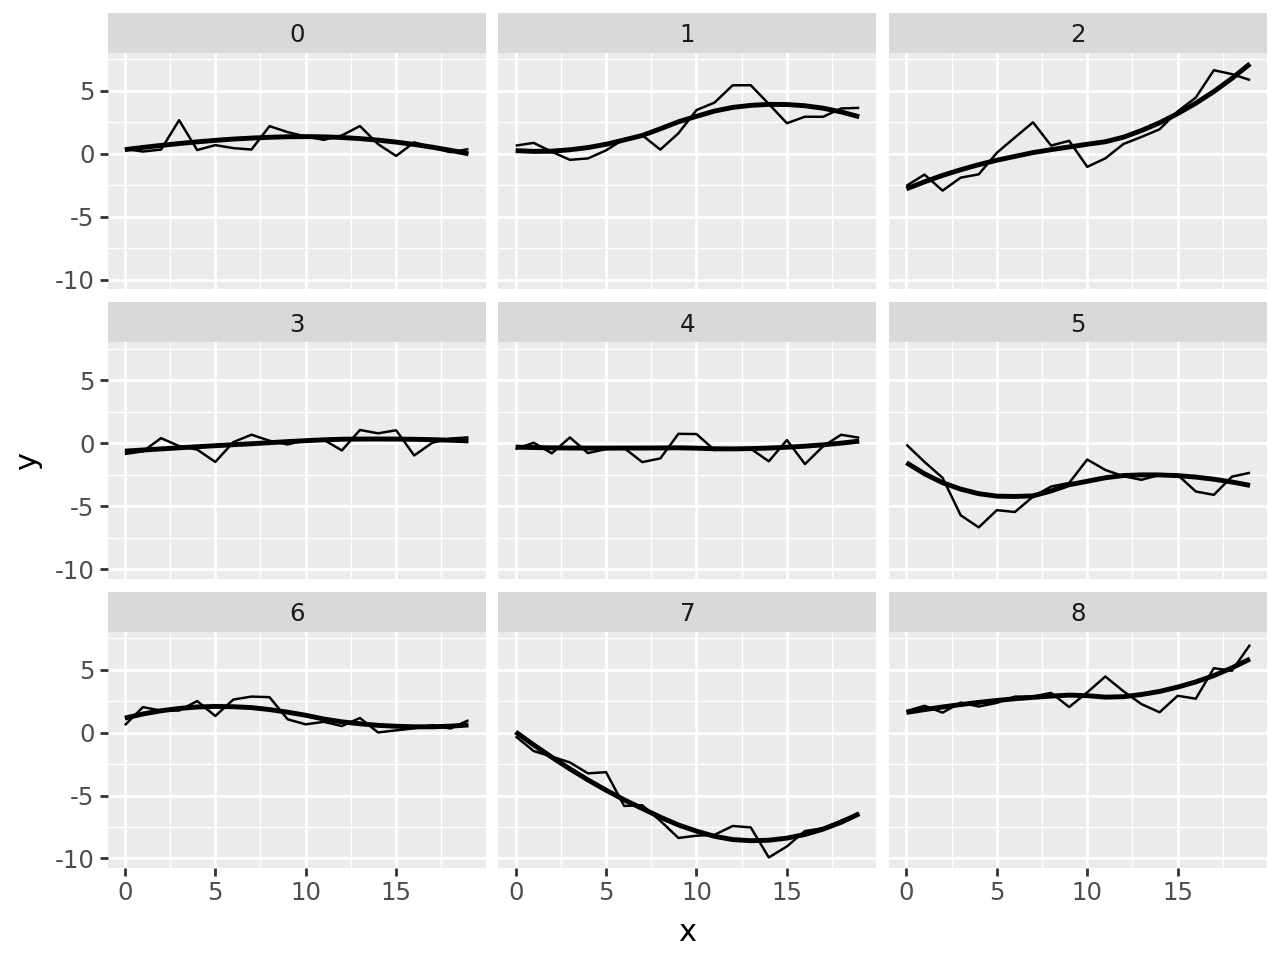

In [16]:
# <!> requires scikit-misc to be installed
ggplot(fd)+aes(x='x', y='y', group='i')+geom_line()+geom_smooth(method='loess', se=False, span=1)+facet_wrap("i")

# Graphs w/ `pyvis`

This library is a wrapper for JS library [https://visjs.org/](visjs).

In [17]:
characters_edges.head()

,name_1,action,name_2
0,Obi-Wan Kenobi,taught,Anakin Skywalker
1,Obi-Wan Kenobi,taught,Luke Skywalker
2,Qui-Gon Jinn,taught,Obi-Wan Kenobi
3,Darth Sidious,taught,Darth Vader
4,Darth Sidious,taught,Darth Maul


In [18]:
color_mapping = {
  'taught': "blue", 
  'was in fact': "yellow", 
  'became': "orange", 
  'parent': "red", 
  'killed': "green"
}

G = Network(height="750px", width="100%", bgcolor="#FFFFFF", font_color="black")

G.add_nodes(set(characters_edges.name_1.tolist()+characters_edges.name_2.tolist()))

for idx, row in characters_edges.iterrows():
  G.add_edge(row['name_1'], row['name_2'], color=color_mapping[row['action']])

G.save_graph("e.html") # unfortunately, need to download and open outside the notebook :'(
# G.show('e.html', notebook=False) # if in .py


# Graphs w/ `plotly`

This library is built on top of D3.js and allows to make very nice graphics. Imo, the syntax can quickly become messy. But the results are bomb.

## Regular plots w/ interactivity

In [22]:
# an interactive scatterplot in a few lines
fig = px.scatter(characters, 
  x="height", 
  y="weight",
  color="gender",
  hover_data=["name", "eye_color"],
  title="Height versus Weight plot"
)
fig.update_layout( width=500, height=500)
fig.show()


In [28]:
# boxplots, which are for some reason named "box"
# by default the hover behavior shows all the different metrics tied to the boxplot -> the arg hover_data set to None disables the hover altogether
fig = px.box(characters, x="height", y="species")
fig.update_layout(hovermode=False)
fig.show()

## Maps

In [29]:
filming_locations

,country,lat,lon
0,Ajim - Mos Eisly spaceport,33.716667,10.750000
1,Gour Beni Mzab - Dunes,33.870000,7.750000
2,Ksar Ommarsia - Mos Espa,33.347450,10.492067


In [30]:
fig = px.scatter_map(filming_locations, 
  lat="lat", 
  lon="lon",
  text="country",
  title="Some locations of SW filming in Tunisia"
)
fig.update_layout( width=750, height=750)
fig.update_traces(hovertemplate='%{text}') #
fig.update_traces(cluster=dict(enabled=True))
fig.show()